# Estimating the Detection Significance of Galaxy-Forest Cross-Correlations

Read in cross-correlatiuons, covariance matrices and null samples

In [12]:
import numpy as np
import copy
import time as time
import lyafxcorr_kg as xcorr
import os.path

from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.io import ascii
from astropy.table import Table
from astropy import units as u

# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib as mpl
mpl.rc('mathtext',fontset='stixsans')
mpl.rc('figure', facecolor="white")
#matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

# Define cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.31)

# Cross-correlation measurements
XCorr_3d = np.load("xcorr_3dhst_v0.npy")
XCorr_zD = np.load("xcorr_zDeep_v0.npy")
XCorr_mosdef = np.load("xcorr_mosdef_v0.npy")
XCorr_vuds = np.load("xcorr_vuds_v0.npy")
XCorr_clamato = np.load("xcorr_clamato_v0.npy")

XNull_3d = np.load("xcorr_rand_3dhst_v0.npy")
XNull_zD = np.load("xcorr_rand_zDeep_v0.npy")
XNull_mosdef = np.load("xcorr_rand_mosdef_v0.npy")
XNull_vuds  = np.load("xcorr_rand_vuds_v0.npy")
XNull_clamato  = np.load("xcorr_rand_clamato_v0.npy")

# Load covariances
Covar_3d = np.load("covar_3dhst_n6400_v0.npy")    
Covar_zD = np.load("covar_zDeep_n6400_v0.npy")
Covar_mosdef = np.load("covar_mosdef_n6400_v0.npy")
Covar_vuds  = np.load("covar_vuds_n6400_v0.npy")
Covar_clamato = np.load("covar_clamato_n6400_v0.npy")

# Read in bin edges
PiBin_fil = 'bins16_pi_0-40hMpc.txt'
SigBin_fil = 'bins10_sigma_0-30hMpc.txt'

PiBins0 = ascii.read(PiBin_fil)
SigBins0 = ascii.read(SigBin_fil)

PiEdges = PiBins0['pi_edges'].data
SigEdges = SigBins0['sigma_edges'].data

# Convert bin boundaries from Mpc/h to Mpc
PiEdges  = PiEdges/(len(PiEdges)*[cosmo.h])
SigEdges = SigEdges/(len(SigEdges)*[cosmo.h])


Plot matrix diagonals

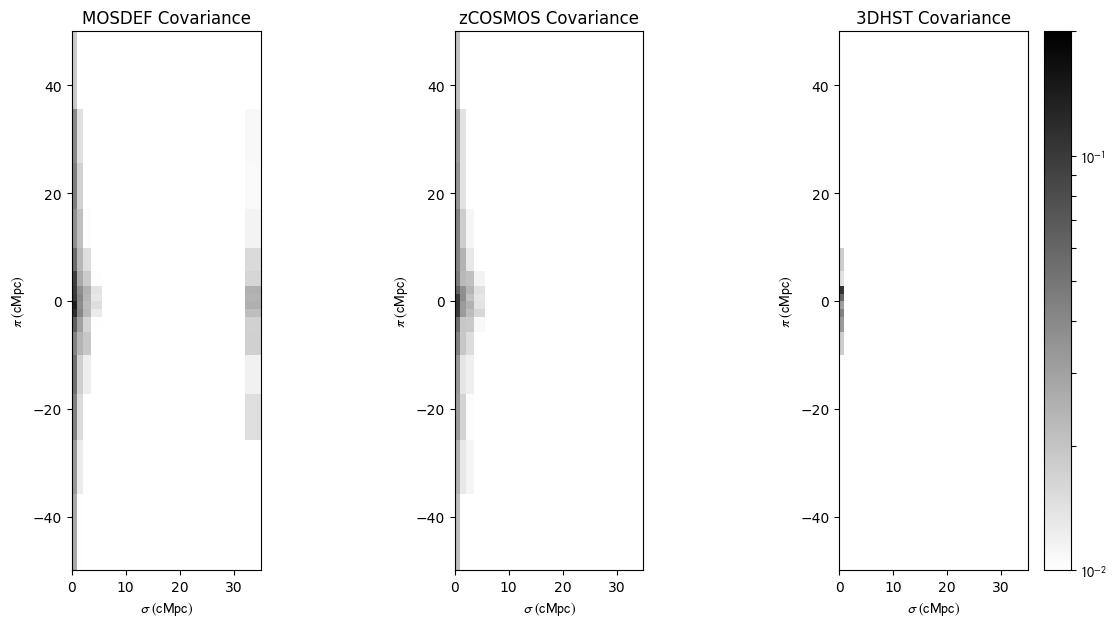

In [13]:
# Plot diagonals of the covariance matrices
DiagCov3d = Covar_3d.diagonal()
DiagCovzD = np.diagonal(Covar_zD)
DiagCovMOS = np.diagonal(Covar_mosdef)

NbinX, NbinY = XCorr_3d.shape
DiagCov3d = DiagCov3d.reshape([NbinX, NbinY])
DiagCovzD = DiagCovzD.reshape([NbinX, NbinY])
DiagCovMOS = DiagCovMOS.reshape([NbinX, NbinY])

X, Y = np.meshgrid(SigEdges, PiEdges)

SigMax = 35.
PiMin = -50.
PiMax = 50.

fig, (ax1, ax2, ax3)= plt.subplots(1,3, figsize=(14,7))

pcm=ax1.pcolormesh(X, Y, DiagCovMOS.transpose(),cmap='gray_r'
                  ,norm=colors.LogNorm(vmin=1.e-3, vmax=0.2))
ax1.set_aspect('equal')
ax1.set_xlim(np.min(X), SigMax)
ax1.set_ylim(PiMin, PiMax)
ax1.set_xlabel(r'$\sigma\; (\mathrm{cMpc})$')
ax1.set_ylabel(r'$\pi\; (\mathrm{cMpc})$')
ax1.set_title("MOSDEF Covariance")
#fig.colorbar(pcm, ax=ax1)

pcm=ax2.pcolormesh(X, Y, DiagCovzD.transpose(),cmap='gray_r'
                   ,norm=colors.LogNorm(vmin=1.e-3, vmax=0.2))
ax2.set_aspect('equal')
ax2.set_xlim(np.min(X), SigMax)
ax2.set_ylim(PiMin, PiMax)
ax2.set_xlabel(r'$\sigma\; (\mathrm{cMpc})$')
ax2.set_ylabel(r'$\pi\; (\mathrm{cMpc})$')
ax2.set_title("zCOSMOS Covariance")
#fig.colorbar(pcm, ax=ax2)

pcm=ax3.pcolormesh(X, Y, DiagCov3d.transpose(),cmap='gray_r'
                   ,norm=colors.LogNorm(vmin=1.e-2, vmax=0.2))
ax3.set_aspect('equal')
ax3.set_xlim(np.min(X), SigMax)
ax3.set_ylim(PiMin, PiMax)
ax3.set_xlabel(r'$\sigma\; (\mathrm{cMpc})$')
ax3.set_ylabel(r'$\pi\; (\mathrm{cMpc})$')
ax3.set_title("3DHST Covariance")

fig.colorbar(pcm, ax=ax3)

#fig.subplots_adjust(wspace=-0.1)

plt.show()

### Estimate MOSDEF Detection Significance

In [14]:
Cov = Covar_mosdef

#fig, ax= plt.subplots()

#print(Cov.shape)
#histdata= Cov.reshape(Cov.size)
#binwidth=0.001
#ax.hist(histdata, bins=np.arange(-0.02,0.02 + binwidth, binwidth))

#plt.show()

print("Condition number = ", np.linalg.cond(Cov))

# Invert the covariance matrix, and see if it's a reasonable inversion
InvCov = np.linalg.pinv(Cov)

UniMat = np.dot(Cov,InvCov)

print(UniMat.diagonal())

#print(UniMat[10:15, 10:15])
print(np.trace(UniMat))
print(np.linalg.det(UniMat))

# This is the vector of data - model (in this case the randoms)
DeltaVec = XCorr_mosdef.reshape(XCorr_mosdef.size) - XNull_mosdef.reshape(XNull_mosdef.size)
print(DeltaVec.shape)

minusLogL = 0.5 * np.dot(DeltaVec.transpose(), np.dot(InvCov, DeltaVec))
print("-ln(L) = ", 0.5 * np.dot(DeltaVec.transpose(), np.dot(InvCov, DeltaVec)))

print("Detection significance = %f sigma" % np.sqrt(minusLogL))
signif_mosdef = np.sqrt(minusLogL)

Condition number =  4803.17465756
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
144.0
1.0
(144,)
-ln(L) =  97.7196635956
Detection significance = 9.885326 sigma


### Estimate CLAMATO Detection Significance

In [15]:
Cov = Covar_clamato

print("Condition number = ", np.linalg.cond(Cov))

# Invert the covariance matrix, and see if it's a reasonable inversion
InvCov = np.linalg.pinv(Cov)

UniMat = np.dot(Cov,InvCov)

print(UniMat.diagonal())

#print(UniMat[10:15, 10:15])
#print(np.trace(UniMat))
print(np.linalg.det(UniMat))

# This is the vector of data - model (in this case the randoms)
DeltaVec = XCorr_clamato.reshape(XCorr_clamato.size) - \
XNull_clamato.reshape(XNull_clamato.size)
print(DeltaVec.shape)

minusLogL = 0.5 * np.dot(DeltaVec.transpose(), np.dot(InvCov, DeltaVec))
print("-ln(L) = ", 0.5 * np.dot(DeltaVec.transpose(), np.dot(InvCov, DeltaVec)))

print("Detection significance = %f sigma" % np.sqrt(minusLogL))
signif_clamato = np.sqrt(minusLogL)

Condition number =  3510.87687422
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
1.0
(144,)
-ln(L) =  63.1746646675
Detection significance = 7.948249 sigma


### Estimate zCOSMOS-Deep Detection Significance

In [16]:
Cov = Covar_zD

print("Condition number = ", np.linalg.cond(Cov))

# Invert the covariance matrix, and see if it's a reasonable inversion
InvCov = np.linalg.pinv(Cov)

UniMat = np.dot(Cov,InvCov)

print(UniMat.diagonal())

#print(UniMat[10:15, 10:15])
#print(np.trace(UniMat))
print(np.linalg.det(UniMat))

# This is the vector of data - model (in this case the randoms)
DeltaVec = XCorr_zD.reshape(XCorr_zD.size) - XNull_zD.reshape(XNull_zD.size)
print(DeltaVec.shape)

minusLogL = 0.5 * np.dot(DeltaVec.transpose(), np.dot(InvCov, DeltaVec))
print("-ln(L) = ", 0.5 * np.dot(DeltaVec.transpose(), np.dot(InvCov, DeltaVec)))

print("Detection significance = %f sigma" % np.sqrt(minusLogL))
signif_zD = np.sqrt(minusLogL)

Condition number =  11242.8230829
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
1.0
(144,)
-ln(L) =  79.7465296427
Detection significance = 8.930091 sigma


### Estimate VUDS Detection Significance

In [17]:
Cov = Covar_vuds

print("Condition number = ", np.linalg.cond(Cov))

# Invert the covariance matrix, and see if it's a reasonable inversion
InvCov = np.linalg.pinv(Cov)

UniMat = np.dot(Cov,InvCov)

print(UniMat.diagonal())

#print(UniMat[10:15, 10:15])
#print(np.trace(UniMat))
print(np.linalg.det(UniMat))

# This is the vector of data - model (in this case the randoms)
DeltaVec = XCorr_vuds.reshape(XCorr_vuds.size) - XNull_vuds.reshape(XNull_vuds.size)
print(DeltaVec.shape)

minusLogL = 0.5 * np.dot(DeltaVec.transpose(), np.dot(InvCov, DeltaVec))
print("-ln(L) = ", 0.5 * np.dot(DeltaVec.transpose(), np.dot(InvCov, DeltaVec)))

print("Detection significance = %f sigma" % np.sqrt(minusLogL))
signif_vuds = np.sqrt(minusLogL)

Condition number =  5786.00086571
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
1.0
(144,)
-ln(L) =  54.5941586736
Detection significance = 7.388786 sigma


### Estimate 3D-HST Detection Significance

In [18]:
Cov = Covar_3d

print("Condition number = ", np.linalg.cond(Cov))

# Invert the covariance matrix, and see if it's a reasonable inversion
InvCov = np.linalg.pinv(Cov)

UniMat = np.dot(Cov,InvCov)

print(UniMat.diagonal())

#print(UniMat[10:15, 10:15])
#print(np.trace(UniMat))
print(np.linalg.det(UniMat))

# This is the vector of data - model (in this case the randoms)
DeltaVec = XCorr_3d.reshape(XCorr_3d.size) - XNull_3d.reshape(XNull_3d.size)
print(DeltaVec.shape)

minusLogL = 0.5 * np.dot(DeltaVec.transpose(), np.dot(InvCov, DeltaVec))
print("-ln(L) = ", 0.5 * np.dot(DeltaVec.transpose(), np.dot(InvCov, DeltaVec)))

print("Detection significance = %f sigma" % np.sqrt(minusLogL))
signif_3d = np.sqrt(minusLogL)

Condition number =  7708.81896593
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
1.0
(144,)
-ln(L) =  45.2519396273
Detection significance = 6.726956 sigma


In [19]:
print("Overall Detection Significance=%f sigma" % 
      np.sqrt(signif_mosdef**2 + signif_zD**2 + signif_clamato**2 +
              signif_vuds**2 + signif_3d**2))

Overall Detection Significance=18.452289 sigma


Just experimenting with matrix inversion here...

In [20]:
A=np.random.rand(10,10)
print("Condition number =", np.linalg.cond(A))
u,s,v=np.linalg.svd(A)
Ainv=np.dot(v,np.dot(np.diag(s**-1),u.transpose()))
#Ainv = np.linalg.pinv(A)

UniMat= np.dot(A, Ainv)

print(UniMat)

print(np.trace(UniMat))
print(np.linalg.det(UniMat))

Condition number = 1775.7423845
[[ -6.22255526e-01  -2.94226977e+00  -1.62382621e+00   1.72866087e+00
   -2.61493847e+00  -5.40061454e-01   2.18531567e+00   3.80685811e+00
   -5.48811614e-01   1.51163377e+00]
 [  2.26850403e+00  -9.43241374e+00  -5.07734657e+00   8.20451154e+00
   -4.21554269e+00  -5.91997990e+00   4.69999657e+00   1.77764052e+01
   -6.15481732e+00   3.20763461e-02]
 [  1.74769069e+01  -7.06441532e+01  -2.59550353e+01   5.77752035e+01
   -2.59893774e+01  -4.14235418e+01   2.83907847e+01   1.21914936e+02
   -5.02208934e+01   7.46904171e+00]
 [  1.29085131e+01  -5.14040593e+01  -1.87261821e+01   4.00067124e+01
   -1.90197873e+01  -3.05188247e+01   2.01871172e+01   8.84860223e+01
   -3.44076568e+01   6.13732845e+00]
 [  3.09488821e+00  -1.46078955e+01  -6.19793330e+00   9.63526432e+00
   -6.15672775e+00  -7.33307353e+00   5.21388998e+00   2.45069623e+01
   -7.09758777e+00   2.62807992e+00]
 [  4.56368354e+00  -2.34176427e+01  -9.29207723e+00   1.85705422e+01
   -9.9758831

### Sanity Check: Comparing Different Null Realizations

# Read in a few null measurements
XNull_0 = np.load("xcorr_rand0_zDeep_v0.npy")
XNull_1 = np.load("xcorr_rand1_zDeep_v0.npy")
XNull_2 = np.load("xcorr_rand2_zDeep_v0.npy")

Cov = Covar_mosdef
DiagCov = Cov.diagonal()
InvCov = np.linalg.pinv(Cov)

Delta0 = XNull_0.reshape(XNull_0.size) - XNull_mosdef.reshape(XNull_zD.size)
Delta1 = XNull_1.reshape(XNull_1.size) - XNull_mosdef.reshape(XNull_zD.size)
Delta2 = XNull_2.reshape(XNull_2.size) - XNull_mosdef.reshape(XNull_zD.size)

print(Delta0.shape, DiagCov.shape)

ChiSqDiag0 = np.reshape(Delta0**2/DiagCov, XNull_0.shape)
ChiSqDiag1 = np.reshape(Delta1**2/DiagCov, XNull_0.shape)
ChiSqDiag2 = np.reshape(Delta2**2/DiagCov, XNull_0.shape)

print("-ln(L)_0 = ", 0.5 * np.dot(Delta0.transpose(), np.dot(InvCov, Delta0)))
print("-ln(L)_1 = ", 0.5 * np.dot(Delta1.transpose(), np.dot(InvCov, Delta1)))
print("-ln(L)_2 = ", 0.5 * np.dot(Delta2.transpose(), np.dot(InvCov, Delta2)))

X, Y = np.meshgrid(SigEdges, PiEdges)

SigMax = 35.
PiMin = -50.
PiMax = 50.

fig, (ax1, ax2, ax3)= plt.subplots(1,3, figsize=(14,7))

ax1.pcolormesh(X, Y, ChiSqDiag0.transpose(), cmap='gray_r' )
ax1.set_aspect('equal')
ax1.set_xlim(np.min(X), SigMax)
ax1.set_ylim(PiMin, PiMax)
ax1.set_xlabel(r'$\sigma\; (\mathrm{cMpc})$')
ax1.set_ylabel(r'$\pi\; (\mathrm{cMpc})$')
#ax1.set_title("MOSDEF: %i galaxies" % len(gal_mosdef))

ax2.pcolormesh(X, Y, ChiSqDiag1.transpose(), cmap='gray_r')
ax2.set_aspect('equal')
ax2.set_xlim(np.min(X), SigMax)
ax2.set_ylim(PiMin, PiMax)
ax2.set_xlabel(r'$\sigma\; (\mathrm{cMpc})$')
ax2.set_ylabel(r'$\pi\; (\mathrm{cMpc})$')
#ax2.set_title("zCOSMOS: %i galaxies" % len(gal_zD))

pcm=ax3.pcolormesh(X, Y, ChiSqDiag2.transpose(), cmap='gray_r')
ax3.set_aspect('equal')
ax3.set_xlim(np.min(X), SigMax)
ax3.set_ylim(PiMin, PiMax)
ax3.set_xlabel(r'$\sigma\; (\mathrm{cMpc})$')
ax3.set_ylabel(r'$\pi\; (\mathrm{cMpc})$')
#ax3.set_title("3DHST: %i galaxies" % len(gal_3d))

fig.colorbar(pcm, ax=ax3)

#fig.subplots_adjust(wspace=-0.1)

plt.show()

The individual null samples are inconsistent with the mean null, when using the covariance matrix. But the latter is determined from the data, so perhaps this makes sense? In other words, the actual data covariances are smaller than would be present from a null sample of the same size?